# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive//Polimi/AN2DL/HW1

Mounted at /gdrive
/gdrive/My Drive/Polimi/AN2DL/HW1


## ⚙️ Import Libraries

In [ ]:
pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 34.5 MB/s eta 0:00:00


In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision

#import keras_cv as kcv
import pandas as pd
import random
from sklearn.model_selection import train_test_split

seed = 42

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

np.random.seed(seed)
tf.random.set_seed(seed);

2.17.1


## ⏳ Load the Data

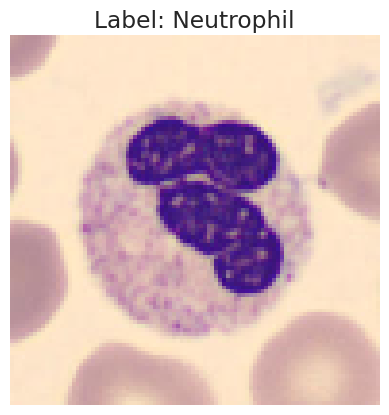

In [ ]:
data = np.load('training_set.npz')
X = data['images'] # Array of 13759 images (96x96x3 each)
y = data['labels'] # Array of 13759 labels (numbers from 0 to 7)



import matplotlib.pyplot as plt

# Get a single batch from the dataset
# If the dataset is batched, take the first image in the batch
image = X[2]  # Take the first image in the batch
label = y[2]  # Take the corresponding label

class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']


# Display the image
plt.imshow(image.astype("uint8"))  # Convert to NumPy and cast to uint8
plt.title(f"Label: {class_names[label[0]]}")  # Convert the label to NumPy for display
plt.axis('off')  # Turn off axis
plt.show()


In [ ]:
data = np.load('training_set.npz')
X = data['images'] # Array of 13759 images (96x96x3 each)
y = data['labels'] # Array of 13759 labels (numbers from 0 to 7)

X = X[:11959]
y = y[:11959]

TEST_SIZE = round(X.shape[0] / 20) # 10%
VAL_SIZE = round(X.shape[0] / 10) # 10%

# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=seed,
    stratify=y
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=VAL_SIZE,
    random_state=seed,
    stratify=y_train_val
)

class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

from sklearn.utils.class_weight import compute_class_weight
y_cw = np.squeeze(y_train)

classes = np.unique(y_cw)
class_weights = compute_class_weight('balanced', classes=classes, y=y_cw)
# Convert to dictionary
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights: "+str(class_weight_dict))

# Convert class labels to categorical format for training, validation, and test sets
y_train = tfk.utils.to_categorical(y_train, num_classes=len(class_names))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(class_names))
y_test = tfk.utils.to_categorical(y_test, num_classes=len(class_names))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Class Weights: {0: 1.755006906077348, 1: 0.6853425026968716, 2: 1.3781182212581344, 3: 0.7378774680603949, 4: 1.7598684210526316, 5: 1.5054798578199051, 6: 0.641729797979798, 7: 0.9095382963493199}
X_train shape: (10165, 96, 96, 3), y_train shape: (10165, 8)
X_val shape: (1196, 96, 96, 3), y_val shape: (1196, 8)
X_test shape: (598, 96, 96, 3), y_test shape: (598, 8)


In [ ]:
BATCH_SIZE = 64
INPUT_SHAPE = (96, 96, 3)
NUM_CLASSES = 8

augmenter = kcv.layers.Augmenter(
    [
        kcv.layers.RandomFlip(),
        kcv.layers.RandAugment(value_range=(0, 255), magnitude=0.4, augmentations_per_image=4),
        kcv.layers.CutMix(),
    ],
)

# Not using this yet
def normalize_data(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to (224, 224, 3)
    # Normalize the image to [0, 1]
    image = image / 255.0
    return image, label

def preprocess_data(images, labels, augment=False):
    inputs = {"images": images, "labels": labels}
    outputs = inputs
    if augment:
        outputs = augmenter(outputs)
    return outputs['images'], outputs['labels']

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

dataset = dataset.batch(BATCH_SIZE).map(
    lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)
#test_dataset = test_dataset.batch(BATCH_SIZE).map(
#    preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
#        tf.data.AUTOTUNE)

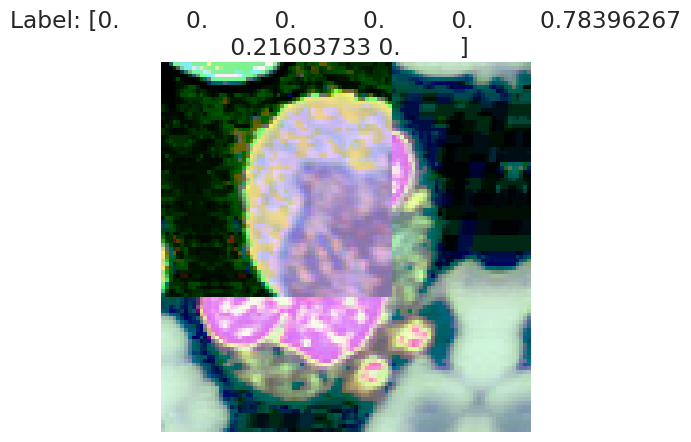

In [ ]:
import matplotlib.pyplot as plt

# Get a single batch from the dataset
for image, label in dataset.take(1):  # Take one batch (or one element if unbatched)
    # If the dataset is batched, take the first image in the batch
    if len(image.shape) == 4:  # Batch shape: (batch_size, height, width, channels)
        image = image[0]  # Take the first image in the batch
        label = label[0]  # Take the corresponding label

    # Display the image
    plt.imshow(image.numpy().astype("uint8"))  # Convert to NumPy and cast to uint8
    plt.title(f"Label: {label.numpy()}")  # Convert the label to NumPy for display
    plt.axis('off')  # Turn off axis
    plt.show()
    break  # Exit after visualizing one image

Initialise MobileNetV3Small model with pretrained weights, for transfer learning

In [ ]:
def senet_block(x, filters, kernel_size=3, padding='same',
                downsample=True, activation='relu', stack=2, name='senet'):

    for s in range(stack):
        # Main convolutional path
        x = tfkl.Conv2D(filters, kernel_size, padding=padding,
                        use_bias=False, name=f'{name}_conv_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act_{s}')(x)

        # Squeeze-and-Excitation (SE) module
        channels = x.shape[-1]

        # Squeeze step
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_squeeze_{s}')(x)

        # Excitation step
        se = tfkl.Dense(channels // 16, activation=activation, name=f'{name}_dense1_{s}')(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=f'{name}_dense2_{s}')(se)

        # Scaling of the output with SE activation
        se = tfkl.Reshape((1, 1, channels))(se)
        x = tfkl.Multiply(name=f'{name}_scale_{s}')([x, se])

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [ ]:


# Define input layer with shape matching the input images
inputs = tfk.Input(shape=INPUT_SHAPE, name='input_layer')

# Define a sequential model for image augmentation with various transformations
augmentation = tf.keras.Sequential([
tfkl.RandomFlip("horizontal_and_vertical"),
tfkl.RandomTranslation(0.1,0.1),
    tfkl.RandomRotation(0.1),
    tfkl.RandomZoom(0.1),
], name='preprocessing')

# Pass augmented inputs through the MobileNetV3Small feature extractor
x = augmentation(inputs, training=True)

 # PART 1
x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1a')(x)
x = tfkl.ReLU(name='relu1a')(x)
x = tfkl.BatchNormalization(name='norm1a')(x)
x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1b')(x)
x = tfkl.ReLU(name='relu1b')(x)
x = tfkl.BatchNormalization(name='norm1b')(x)
x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)


# PART 2
x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2a')(x)
x = tfkl.ReLU(name='relu2a')(x)
x = tfkl.BatchNormalization(name='norm2a')(x)
x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2b')(x)
x = tfkl.ReLU(name='relu2b')(x)
x = tfkl.BatchNormalization(name='norm2b')(x)
x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)


# PART 3
x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv3a')(x)
x = tfkl.ReLU(name='relu3a')(x)
x = tfkl.BatchNormalization(name='norm3a')(x)
x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv3b')(x)
x = tfkl.ReLU(name='relu3b')(x)
x = tfkl.BatchNormalization(name='norm3b')(x)
#x = kcv.layers.SqueezeAndExcite2D(filters=128)(x)
x = tfkl.MaxPooling2D(pool_size=2, name='mp3')(x)



# PART 4
x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv4a')(x)
x = tfkl.ReLU(name='relu4a')(x)
x = tfkl.BatchNormalization(name='norm4a')(x)
x = kcv.layers.SqueezeAndExcite2D(filters=256)(x)
x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv4b')(x)
x = tfkl.ReLU(name='relu4b')(x)
x = tfkl.BatchNormalization(name='norm4b')(x)
x = kcv.layers.SqueezeAndExcite2D(filters=256)(x)
x = tfkl.MaxPooling2D(pool_size=2, name='mp4')(x)

# PART 5
x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv5a')(x)
x = tfkl.ReLU(name='relu5a')(x)
x = tfkl.BatchNormalization(name='norm5a')(x)
x = kcv.layers.SqueezeAndExcite2D(filters=512)(x)
x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv5b')(x)
x = tfkl.ReLU(name='relu5b')(x)
x = tfkl.BatchNormalization(name='norm5b')(x)
x = tfkl.MaxPooling2D(pool_size=2, name='mp5')(x)

x = tfkl.GlobalAveragePooling2D(name='gap')(x)


# Add a dense layer for final output processing
x = tfkl.Dropout(0.5, name='dropout1')(x)
x = tfkl.Dense(512,name='dense1')(x)
x = tfkl.Activation('relu', name='act1')(x)

x = tfkl.Dense(256, name='dense2')(x)
x = tfkl.Activation('relu', name='act2')(x)

x = tfkl.Dense(8, name='dense3')(x)
outputs = tfkl.Activation('softmax', name='softmax')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
loss = tfk.losses.CategoricalCrossentropy(label_smoothing=0.1)
optimizer = tfk.optimizers.Lion(9e-4)
metrics = ['accuracy']
tl_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_2            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1a (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu1a (ReLU)                        │ (None, 96, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ norm1a (BatchNormalization)          │ (None, 96, 96, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1b (Conv2D)                      │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu1b (ReLU)                        │ (None, 96, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ norm1b (BatchNormalization)          │ (None, 96, 96, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp1 (MaxPooling2D)                   │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2a (Conv2D)                      │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu2a (ReLU)                        │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ norm2a (BatchNormalization)          │ (None, 48, 48, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2b (Conv2D)                      │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu2b (ReLU)                        │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ norm2b (BatchNormalization)          │ (None, 48, 48, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp2 (MaxPooling2D)                   │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,314,088 (20.27 MB)

 Trainable params: 5,310,120 (20.26 MB)

 Non-trainable params: 3,968 (15.50 KB)

## 🛠️ Train and Save the Model

In [ ]:
# Add your implementation here
model = tl_model

# Train the model
history = model.fit(
    dataset,
    batch_size = 64,
    epochs = 110,
    validation_data = (X_val, y_val),
    class_weight = class_weight_dict,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=14, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/110
 92/159 ━━━━━━━━━━━━━━━━━━━━ 10:22 9s/step - accuracy: 0.1455 - loss: 2.3044

KeyboardInterrupt: 

In [ ]:
model.save('weights.keras')
del model

TEST ON THE HOLD OUT TEST SET

In [ ]:
class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'squeeze_and_excite2d_19', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'squeeze_and_excite2d_20', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Predictions Shape: (598,)
[2 6 6 7 1 6 7 3 1 7 0 5 5 1 3 3 6 4 3 3 6 4 2 3 2 4 7 7 5 3 3 3 3 0 7 2 6
 5 5 2 7 5 7 5 0 3 3 3 0 0 1 1 3 1 2 7 1 3 1 3 3 3 3 1 7 6 3 5 0 4 5 6 6 3
 0 1 6 3 6 4 1 4 7 6 6 1 3 3 7 6 6 3 3 6 5 4 1 3 1 6 4 3 3 3 1 0 0 7 6 0 3
 1 1 2 3 5 0 6 1 6 1 0 1 0 7 5 1 2 7 7 1 4 1 5 5 3 6 7 5 7 5 2 7 1 6 3 0 5
 5 5 6 6 1 1 1 4 3 6 3 6 1 2 5 6 4 5 7 0 2 1 0 7 7 4 6 7 7 1 3 3 1 3 3 2 0
 0 3 4 4 2 3 2 2 1 6 7 2 1 1 6 6 7 7 1 4 7 4 0 3 6 3 2 3 0 7 1 3 6 7 7 3 4
 1 7 6 1 3 3 6 1 1 6 6 7 1 6 2 4 2 6 2 1 6 3 1 0 2 7 2 0 6 2 3 3 0 6 2 4 3
 7 0 3 2 4 3 7 3 3 4 6 7 2 6 4 1 2 3 6 6 3 6 5 3 1 7 6 3 1 6 1 6 6 1 6 2 6
 4 6 1 7 2 5 0 1 1 5 3 7 4 6 5 3 7 5 1 5 7 7 0 6 0 1 4 6 6 6 6 3 0 6 2 6 2
 7 5 5 3 3 3 4 7 1 3 3 2 7 1 3 4 6 5 3 3 6 6 1 2 0 6 1 1 6 5 4 3 7 1 1 1 0
 7 1 3 5 1 6 3 1 1 7 2 2 6 3 3 1 1 6 6 1 5 1 5 6 6 2 1 4 2 2 0 4 1 6 3 6 2
 6 1 3 2 5 2 7 7 7 1 0 7 6 5 5 3 1 3 0 0 0 6 1 1 7 7 7 7 3 5 1 4 7 7 5 6 6
 6 6 3 6 1 2 6 1 6 1 6 2 1 6 4 6 6

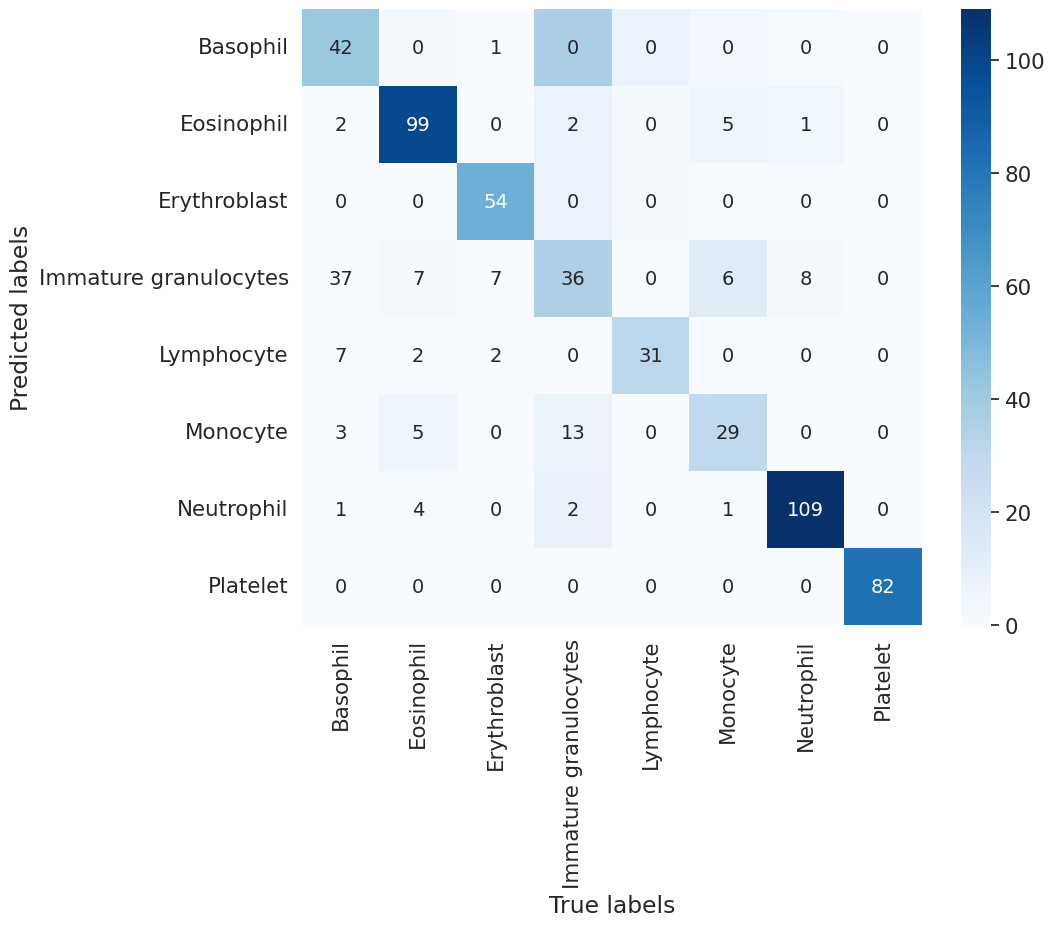

In [ ]:
# Predict labels for the entire test set
model = Model()

predictions = model.predict(X_test)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)
print(true_classes)
# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, predictions)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, predictions, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, predictions, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, predictions, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predictions)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(class_names), yticklabels=list(class_names), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 14%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>